# Twitter author prediction

Elemzésünkben Donald Trump és Hilary Clinton tweetjeit fogjuk vizsgálni. A célunk az, hogy a tweetek alapján megpróbáljuk megjósolni, hogy melyikük írta a tweetet. A kutatási kérdésünk az, hogy melyik modellt érdemes erre a célra használni és melyiknek mi az erőssége, hibája.

## Prerequisites

### Importing necessary libraries

In [1]:
import random; random.seed(53)
import pandas as pd

# Import all we need from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import itertools
import numpy as np
import matplotlib.pyplot as plt

A következő csak egy segédfüggvény, ami majd később segít megjeleníteni a confusion mátrixot.

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figure=0):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figure)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Load the data

In [3]:
# Load data
tweet_df = pd.read_csv("C:/Users/Oliver/Documents/BCE/Tárgyak/9. félév/Többváltozós statisztika/tweets_1.csv")
#extract the texts and the authors where the author is either HillaryClinton or realDonaldTrump
tweet_df = tweet_df[tweet_df.is_retweet == False]
tweet_df = tweet_df[["handle", "text"]]
tweet_df.columns = ["author", "status"]


Az eredeti adatbázisban voltak tweetek és retweetek is, de mi csak a tweeteket használjuk fel. Tehát a felhasznált oszlopok a következőképpen néznek ki:

In [4]:
tweet_df.head()

,author,status
0,HillaryClinton,The question in this election: Who can put the...
3,HillaryClinton,"If we stand together, there's nothing we can't..."
4,HillaryClinton,Both candidates were asked about how they'd co...
5,realDonaldTrump,Join me for a 3pm rally - tomorrow at the Mid-...
6,HillaryClinton,This election is too important to sit out. Go ...


Így oszlanak meg a tweetek a két politikus között:

In [5]:
tweet_df.value_counts("author")

author
realDonaldTrump    3093
HillaryClinton     2629
Name: count, dtype: int64

A következő sorokban szétbontjuk az adatbázist train és test részekre.  
A train rész lesz az, amit felhasználunk a modell tanításához, a test pedig a modell teszteléséhez. Ami érdekes beállítás, hogy a train_test_split függvényben a stratify paramétert a címkére állítjuk, így biztosítva, hogy a train és test részekben is ugyanolyan arányban legyenek a címkék.  
A test_size paraméterrel pedig azt állítjuk be, hogy a teljes adatbázis 10%-át használjuk fel tesztelésre. Ez elsőre alacsonynak tűnhet, de a train seten is cross validationt fogunk használni, az overfittinget elkerülendő. _Később meglátjuk, hogy ez mennyire volt jó döntés._

In [6]:
# Create target
x = tweet_df["status"]

y = tweet_df["author"]

# Split training and testing data

X_train, X_test, y_train, y_test = train_test_split(x, y,  test_size=0.1, stratify=y, random_state=42)

## Data cleaning

Ebben a részben a tweeteket tokenné alakítjuk két különböző módszerrel. Az egyik módszer a CountVectorizer, a másik pedig a TfidfVectorizer. A kettő közötti különbség, hogy a CountVectorizer csak a szavak előfordulását számolja, míg a TfidfVectorizer a szavak előfordulását szorozza a szavak inverse document frequency-jével. Az inverse document frequency azt mutatja meg, hogy egy szó mennyire jellemző egy adott dokumentumra.   
__Lényegében tehát a TfidfVectorizer a CountVectorizer egy fejlettebb változata, ami a gyakran előforduló szavakat alulreprezentálja, a ritka szavakat pedig felül.__
_https://en.wikipedia.org/wiki/Tf%E2%80%93idf_

### CountVectorizer

In [7]:
count_vectorizer = CountVectorizer(stop_words="english", min_df=0.01, max_df=0.9)
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

Itt beállítjuk, hogy mekkora legyen a minimum és a maximum előfordulás, amit még figyelembe veszünk. A stop_words paraméterrel pedig azt állítjuk be, hogy milyen szavakat ne vegyen figyelembe a CountVectorizer. Ezek a szavak általában nem sokatmondóak a modellek szempontjából, mint például a névelők, elöljárószók, stb.

Egyébként itt egy óriási sparse matrixot kapunk, de ezt jól kezeli a python. Ha kisebb mátrixot szeretnénk, akkor a min_df és a max_df paramétereket szűkebbre állíthatjuk.  
Ilyen szavakat kapunk:

In [8]:
print(count_vectorizer.vocabulary_)

{'look': 57, 'amp': 6, 'party': 74, 'makeamericagreatagain': 60, 'https': 43, 'let': 52, 'make': 59, 'family': 34, 'america': 2, 'people': 76, 'right': 85, 'want': 114, 'thank': 99, 've': 110, 'campaign': 13, 'donald': 29, 'trump': 107, 'tax': 97, 'plan': 77, 'national': 68, 'years': 126, 'proud': 81, 'tonight': 105, 'women': 120, 'million': 64, 'vote': 111, 'today': 103, 'new': 70, 'york': 127, 'hillary': 41, 'know': 51, 'like': 54, 'trump2016': 108, 'join': 49, 'clinton': 18, 'candidate': 14, 'says': 89, 'country': 20, 'president': 80, 'obama': 73, 'american': 4, 'economy': 30, 'americans': 5, 'realdonaldtrump': 82, 'man': 62, 'good': 37, 'wants': 115, 'great': 39, 'making': 61, 'things': 100, 'watch': 116, 'votetrump': 112, 'night': 72, 'said': 87, 'work': 122, 'change': 17, 'really': 83, 'amazing': 1, 'ted': 98, 'cruz': 23, 'win': 118, 'doesn': 27, 'stop': 94, 'time': 102, 'money': 66, 'won': 121, 'support': 95, 'foxnews': 35, 'history': 42, 'united': 109, 'states': 93, 'don': 28, 

### Tf-Idf

In [9]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=0.01, max_df=0.9)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

Itt ugyanazt tudjuk elmondani a paraméterekről, mint a CountVectorizer esetében.  
A kapott szavak persze ugyanazok, de a sparse mátrixban nem a darabszámuk szerepel, hanem az inverse document frequency-jük.

_Érdekesség_:

tf: Term Frequency - a szó előfordulásának gyakorisága az adott tweetben
$$\text{tf}(t, d) = \frac{f_{t,d}}{\sum_{t' \in d} f_{t',d}}$$
idf: Inverse Document Frequency - a tweetek száma osztva azzal, hogy hány tweetben szerepel az adott szó, majd ennek a logaritmusa
$$\text{idf}(t, D) = \log \frac{N}{|\{d \in D : t \in d\}|}$$
tf-idf: Term Frequency - Inverse Document Frequency - a szó jellemzősége az adott tweetre nézve
$$\text{tfidf}(t, d, D) = \text{tf}(t, d) \cdot \text{idf}(t, D)$$


In [10]:
print(tfidf_vectorizer.vocabulary_)

{'look': 57, 'amp': 6, 'party': 74, 'makeamericagreatagain': 60, 'https': 43, 'let': 52, 'make': 59, 'family': 34, 'america': 2, 'people': 76, 'right': 85, 'want': 114, 'thank': 99, 've': 110, 'campaign': 13, 'donald': 29, 'trump': 107, 'tax': 97, 'plan': 77, 'national': 68, 'years': 126, 'proud': 81, 'tonight': 105, 'women': 120, 'million': 64, 'vote': 111, 'today': 103, 'new': 70, 'york': 127, 'hillary': 41, 'know': 51, 'like': 54, 'trump2016': 108, 'join': 49, 'clinton': 18, 'candidate': 14, 'says': 89, 'country': 20, 'president': 80, 'obama': 73, 'american': 4, 'economy': 30, 'americans': 5, 'realdonaldtrump': 82, 'man': 62, 'good': 37, 'wants': 115, 'great': 39, 'making': 61, 'things': 100, 'watch': 116, 'votetrump': 112, 'night': 72, 'said': 87, 'work': 122, 'change': 17, 'really': 83, 'amazing': 1, 'ted': 98, 'cruz': 23, 'win': 118, 'doesn': 27, 'stop': 94, 'time': 102, 'money': 66, 'won': 121, 'support': 95, 'foxnews': 35, 'history': 42, 'united': 109, 'states': 93, 'don': 28, 

## Training the models

Ebben a fejezetben definiáljuk a felhasznált modelleket, és tanítjuk is őket.

A CountVectorizerrel kapott adatokat nem használjuk fel, csak a TfidfVectorizerrel kapottakat. Ennek egyszerű oka, hogy mindig jobban teljesít a TfidfVectorizerrel kapott adatokon tanított modell, mint a CountVectorizerrel kapott adatokon tanított modell.

Minden modell esetében a következő lépések történnek:
1. A modell létrehozása
2. Modell lehetséges hiperparamétereinek megadása
3. A hiperparaméterek terén egy __cross validációs optimalizáció futtatása Grid Search-el__ (azaz végigmegyünk az összes lehetséges hiperparaméter kombináción, amit megadtunk, és megnézzük, hogy melyik kombináció adja a legjobb eredményt). Ezt lehetne randomizálni, de felesleges, így is lefutnak másodpercek alatt a tanulások.
1. A legjobb hiperparaméterekkel új modell létrehozása, ezekkel fogjuk kiértékelni a modellt a test seten.

Minden modell alatt ki lesz írva, hogy a legjobb estimator milyen hiperparaméterekkel rendelkezik.

_Megjegyzés 1: Ezért nem gond, hogy 90%-os nagyságú a train setünk, mert még ezen belül is cross validációt használunk. Tehát gyakorlatilag olyan, mintha lenne egy train, egy validation és egy test setünk. Csak a cross validation miatt a validation set mindig más._

_Megjegyzés 2: A hiperparaméterek terét erősebb géppel nagyobbnak is lehetne állítani, de ezek így még a legtöbb gépen elfutnak._

_Megjegyzés 3: A Random Search jobban bevett módszer, mint a Grid Search, de a Grid Search egyszerűbb, és a kis hiperparaméter tereken még le is fut. Majd később látjuk, hogy support vectorokból csak egy félét csináltunk, ennek oka, hogy nem volt elég erős gépünk, ami belátható időn belül megcsinálta volna az optimalizációt minden módszerrel, minden hiperparaméterre._

### Training a multinomial naive Bayes model

Először egy multinomiális naív Bayes modellt alkotunk. 

Itt a következő hiperparamétereket állítjuk be:
- __alpha__: ez egy smoothing paraméter, ami azt szabályozza, hogy mennyire legyenek simák a döntési határok. Ha ez a paraméter 0, akkor a modell nem fogja tudni kezelni azokat a szavakat, amiket a tanító adatbázisban nem látott. Ha ez a paraméter túl nagy, akkor pedig a modell túl sima lesz, és semmitmondó eredményeket fogunk kapni.
- __fit_prior__: ez egy boolean, ami azt szabályozza, hogy a modellnek legyenek-e saját priorjai, vagy pedig a tanító adatbázisban látott előfordulások alapján számolja ki a priorokat.

In [11]:
# Create and fit the model for the tf-idf data
param_grid_nb = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
    'fit_prior': [True, False],
}
tf_idf_nb_cv = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5)
tf_idf_nb_cv.fit(tfidf_train, y_train)
tf_idf_nb = tf_idf_nb_cv.best_estimator_
tf_idf_nb_pred = tf_idf_nb.predict(tfidf_test)
print("Best parameters: {}".format(tf_idf_nb_cv.best_params_))


Best parameters: {'alpha': 10.0, 'fit_prior': True}


### Training an SVM model

Itt az SVM-ek legegyszerűbb változatát használjuk, a lineáris support vector machine-t.  
A következő hiperparamétereket állítjuk be:
- __C__: ez egy regularization paraméter, ami azt szabályozza, hogy mennyire legyenek simák a döntési határok. Ha ez a paraméter túl nagy, akkor a modell túl sima lesz, és semmitmondó eredményeket fogunk kapni. Ha túl kicsi, akkor pedig a modell túl zajos lesz, és overfitteléshez vezethet. _Gyakorlatiliag a hipersík elhelyezkedését szabályozza a pontokhoz képest, minél kisebb a C, annál jobban bűnteti a hipersíkhoz közeli ponotokat._
- __dual__: Ez csak a megoldási algoritmusra van hatással, azt mutatja, hogy az optimalizálási feladat primál vagy duál feladatát oldja-e meg az algoritmus. Lehet, hogy közelítési hibák miatt van különbség a kettő között, ezért erre a paraméterre is optimalizálunk, persze ez nem lenne szükséges.

In [12]:
param_grid_svc = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "dual": [True, False],
}
tf_idf_svc_cv = GridSearchCV(LinearSVC(), param_grid=param_grid_svc, cv=5)
tf_idf_svc_cv.fit(tfidf_train, y_train)
tf_idf_svc_pred = tf_idf_svc_cv.predict(tfidf_test)
tf_idf_svc = tf_idf_svc_cv.best_estimator_
print("Best parameters: {}".format(tf_idf_svc_cv.best_params_))



Best parameters: {'C': 0.01, 'dual': True}


Fontos megjegyezni, hogy itt a legkevésbé sem használtuk ki az SVM-ekben rejlő potenciált, mivel csak egy lineáris SVM-et használtunk, ami nem tud nem lineárisan szeparálható adatokon tökéletesen teljesíteni.

### Training a logistic regression model

Itt egy logisztikus regressziós modellt használunk.

A hiperparaméter a következő:
- __C__: Ez is egy regulizációs paraméter, ami bünteti a nagyobb paramétereket. Ezt is persze az overfitting elkerülése végett használjuk.

In [13]:
param_grid_lr = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10]
}
tf_idf_lr_cv = GridSearchCV(LogisticRegression(), param_grid=param_grid_lr, cv=5)
tf_idf_lr_cv.fit(tfidf_train, y_train)
tf_idf_lr = tf_idf_lr_cv.best_estimator_
tf_idf_lr_pred = tf_idf_lr.predict(tfidf_test)
print("Best parameters: {}".format(tf_idf_lr_cv.best_params_))

Best parameters: {'C': 1}


### Training a decision tree model

Döntési fa, na itt már izgalmasabb hiperparaméterek is vannak.

- __criterion__: Ez a módszer, ami alapján az egyes spliteket csinálja az algoritmus. Kettőt próbáltunk, a ginit és az entropyt.
- __max_depth__: Ez a paraméter azt szabályozza, hogy milyen mély legyen maximálisan a döntési fa. Ha túl nagy, akkor overfitteléshez vezethet, ha túl kicsi, akkor pedig nem lesz elég pontos a modell.
- __min_samples_leaf__: Ez a paraméter azt szabályozza, hogy egy levélben hány elem legyen minimum.

In [14]:
param_grid_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8]
}
tf_idf_dt_cv = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid_dt, cv=5, n_jobs=-1)
tf_idf_dt_cv.fit(tfidf_train, y_train)
tf_idf_dt = tf_idf_dt_cv.best_estimator_
tf_idf_dt_pred = tf_idf_dt.predict(tfidf_test)
print("Best parameters: {}".format(tf_idf_dt_cv.best_params_))

Best parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2}


### Training a random forest model

Na itt már maga a modell is érdekesebb, ugyanis ez egy bagginges random forest modell.  
Itt tehát folyamatosan bootsrappeljük nemcsak a megfigyeléseket, hanem a feature-öket is.

A hiperparaméterek a következők:
- __n_estimators__: Ez a paraméter azt szabályozza, hogy hány döntési fát használjunk a modellben. Minél többet használunk, annál pontosabb lesz a modell, de annál több erőforrást is fog igénybe venni.
- __max_samples__: Ez a paraméter azt szabályozza, hogy egy döntési fa mennyi megfigyelést használjon fel a tanuláshoz. Minél többet használunk, annál pontosabb lesz a modell, de annál több erőforrást is fog igénybe venni. (itt, ha floatot adunk meg, akkor az összes megfigyelés 80%-át használja fel a tanuláshoz)
- __max_features__: Ez a paraméter azt szabályozza, hogy egy döntési fa mennyi feature-t használjon fel a tanuláshoz. Minél többet használunk, annál pontosabb lesz a modell, de annál több erőforrást is fog igénybe venni. (itt, ha floatot adunk meg, akkor az összes változó (token) 80%-át használja fel a tanuláshoz)
- __random_state__: ez egy seed állítás, hogy reprodukálható eredményeket kapjunk.
- __n_jobs__: ez a paraméter azt szabályozza, hogy hány magot használjon fel a gép a modell tanításához. Ha -1-et adunk meg, akkor az összes magot felhasználja.

In [15]:
tf_idf_rf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, max_samples=0.8, max_features=0.8, random_state=42, n_jobs=-1)
tf_idf_rf.fit(tfidf_train, y_train)
tf_idf_rf_pred = tf_idf_rf.predict(tfidf_test)

## Accuracy scores (for the tf-idf vectorizer)

Az adatbázisunk elemzése során számos helyességet és pontosságot mérő mutatót alkalmaztunk. A következőekben ezeket a mutatókat fogjuk ismertetni. 

In [16]:
target_values = list(tf_idf_lr.classes_)

### Confusion matrices

A confusion mátrixot a klasszifikáció pontosságának a kiértékeléséhez hoztuk létre. 

Általánosan egy C confusion mátrix olyan, hogy $C(i,j)$ jelöli azokat a megfigyeléseket, amikről tudjuk, hogy az $i$ csoportba tartoznak és a $j$ pedig az a csoport, amelyikbe az előrejelzés teszi. Soronként látjuk a valóságban előforduló osztályokat, oszloponként pedig a predikált osztályokat.

(Bináris klasszifikáció esetén (esetünkben) $C(0,0)$ az true negatives, $C(1,0)$ a false negatives, $C(1,1)$ a true positives és $C(0,1)$ a false positives száma.) 


A ’normalize’ paraméter ’true’ beállítása azt jelenti, hogy soronként normáltuk a mátrixot.

Naive Bayes


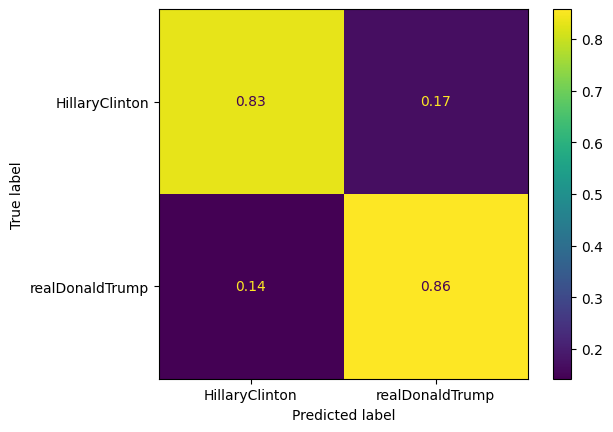

In [17]:
print("Naive Bayes")
tf_idf_nb_cm = metrics.confusion_matrix(y_test, tf_idf_nb_pred, labels=target_values, normalize='true')
metrics.ConfusionMatrixDisplay(tf_idf_nb_cm, display_labels=target_values).plot()

Ez a modell az esetek 83%-ában jelezte elő helyesen a Hillary Clinton tweet-eket és csak 17%-ban hitte Donald Trump tweet-jeinek Clintonét, amíg Trump bejegyzéseit 86%-os sikerrel találta el és csupán az esetek 14%-ában tévedett és tekintette Clinton tweet-jeinek Trumpét. 

SVM


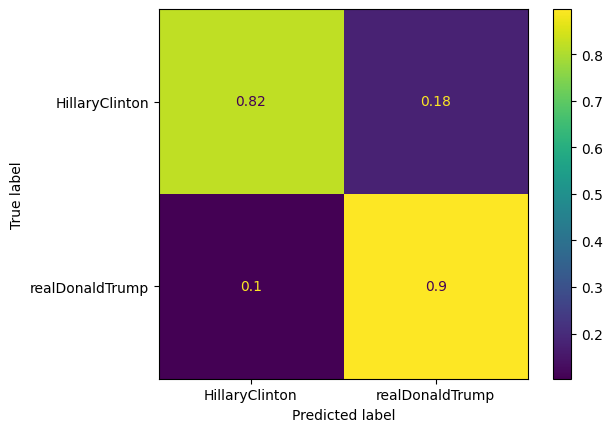

In [18]:
print("SVM")
tf_idf_svc_cm = metrics.confusion_matrix(y_test, tf_idf_svc_pred, labels=target_values, normalize='true')
metrics.ConfusionMatrixDisplay(tf_idf_svc_cm, display_labels=target_values).plot()

A Naive Bayes-nél jelentősen jobb eredményeket ért el Trump-nál. Clinton bejegyzéseit a bayes-ihez hasonló, 82%-os aránnyal, Trump-ét 90%-os pontossággal találta el.

Logistic Regression


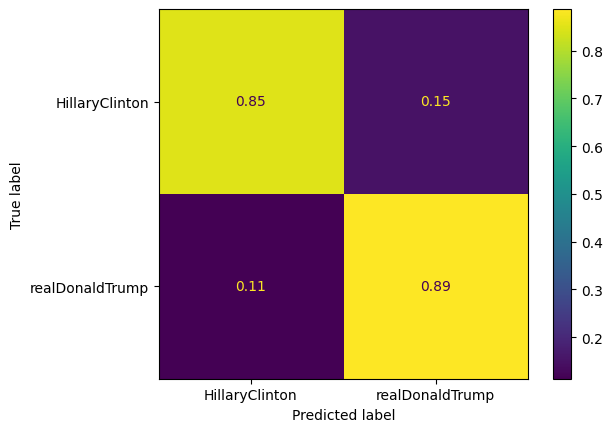

In [19]:
print("Logistic Regression")
tf_idf_lr_cm = metrics.confusion_matrix(y_test, tf_idf_lr_pred, labels=target_values, normalize='true')
metrics.ConfusionMatrixDisplay(tf_idf_lr_cm, display_labels=target_values).plot()

Ez a modell összességében még jobbnak tekinthető az előző kettőnél, Clinton tweet-jeit mindkettőnél pontosabban, Trump-ét az SVM-hez nagyon hasonlóan és a bayes-inél jobban jelezte elő, 85 és 89%-os siker aránnyal.

Decision Tree


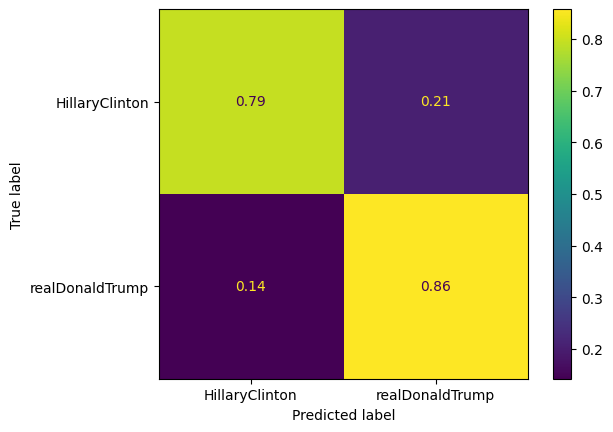

In [20]:
print("Decision Tree")
tf_idf_dt_cm = metrics.confusion_matrix(y_test, tf_idf_dt_pred, labels=target_values, normalize='true')
metrics.ConfusionMatrixDisplay(tf_idf_dt_cm, display_labels=target_values).plot()


Clinton esetében és összességében is a leggyengébb modell, ugyanakkor mégis egy általánosságban magasnak tekinthető 79%-os sikerrel ismerte fel Clinton bejegyzéseit és az esetek 21%-ában hibázott és azonosította Trump-éként Clinton tweet-jeit, amíg Trump-nál 86%-os pontosságot mutatott. 

Random Forest with bagging


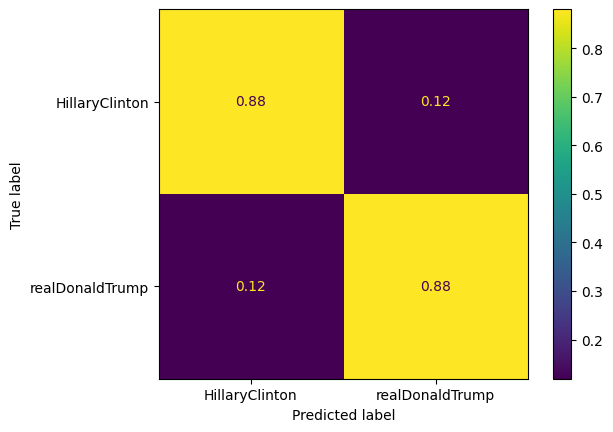

In [21]:
print("Random Forest with bagging")
tf_idf_rf_cm = metrics.confusion_matrix(y_test, tf_idf_rf_pred, labels=target_values, normalize='true')
metrics.ConfusionMatrixDisplay(tf_idf_rf_cm, display_labels=target_values).plot()

A Random Forest egyformán hatékonyan, egy teljesen kiegyensúlyozott eredményt mutatott, 88%-ban jelezte helyesen elő mindkét politikus bejegyzéseit, ami nagyon magas érték és összességében a confusion mátrixok alapján a legjobbnak minősíthető.

Itt megtekinthetjük a confusion mátrixokat normalizálás nélkül:

In [22]:
tf_idf_nb_cm = metrics.confusion_matrix(y_test, tf_idf_nb_pred, labels=target_values)
tf_idf_svc_cm = metrics.confusion_matrix(y_test, tf_idf_svc_pred, labels=target_values)
tf_idf_lr_cm = metrics.confusion_matrix(y_test, tf_idf_lr_pred, labels=target_values)
tf_idf_dt_cm = metrics.confusion_matrix(y_test, tf_idf_dt_pred, labels=target_values)
tf_idf_rf_cm = metrics.confusion_matrix(y_test, tf_idf_rf_pred, labels=target_values)

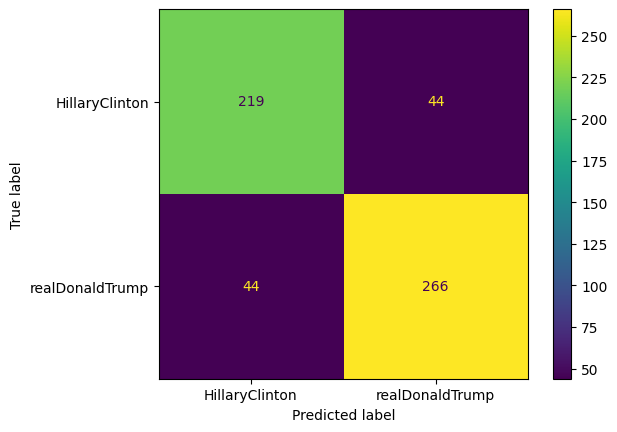

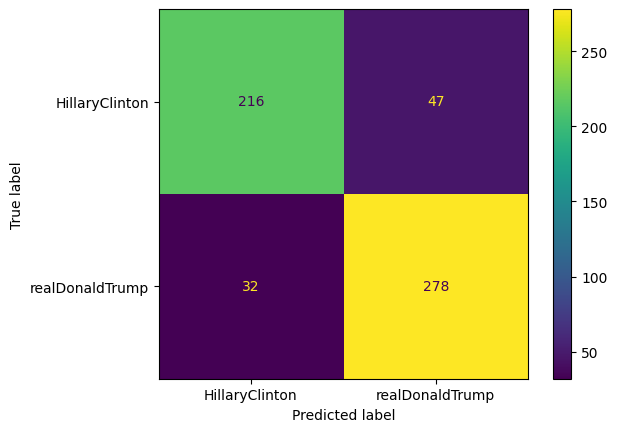

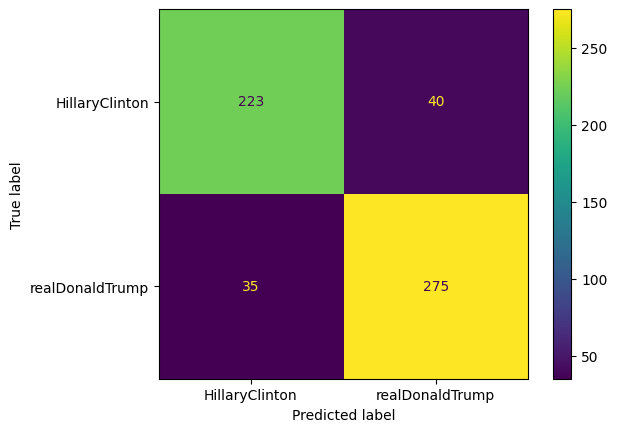

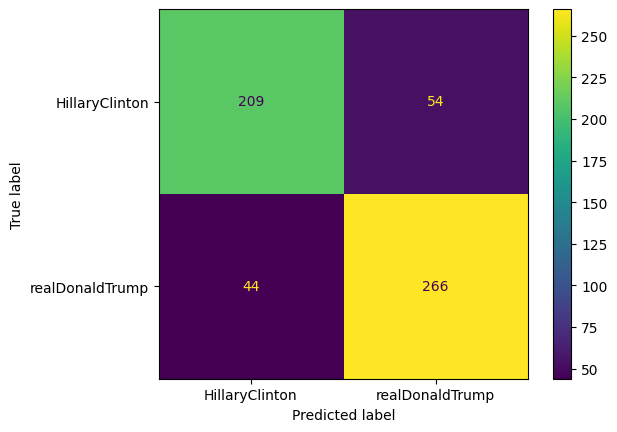

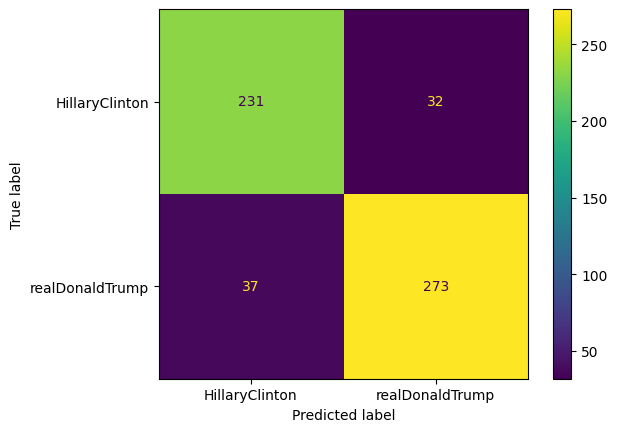

In [23]:
metrics.ConfusionMatrixDisplay(tf_idf_nb_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_svc_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_lr_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_dt_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_rf_cm, display_labels=target_values).plot()

### Accuracy scores of the models (on the test set)

Az accuracy score helyes előrejelzések és az összes előrejelzés teljes számának hányadosaként kapható meg. $$\frac{TP+TN}{TP+TN+FP+FN}$$
Magyarán, hogy hány százalékban helyes az előrejelzés.

A test seten kapott eredmények a következők:

In [24]:
print("Naive Bayes\t\t", tf_idf_nb.score(tfidf_test, y_test))
print("SVC\t\t\t", tf_idf_svc.score(tfidf_test, y_test))
print("Logistic Regression\t", tf_idf_lr.score(tfidf_test, y_test))
print("Decision Tree\t\t", tf_idf_dt.score(tfidf_test, y_test))
print("Random Forest\t\t", tf_idf_rf.score(tfidf_test, y_test))

Naive Bayes		 0.8464223385689355
SVC			 0.8621291448516579
Logistic Regression	 0.8691099476439791
Decision Tree		 0.8289703315881326
Random Forest		 0.8795811518324608


A train seten kapott eredmények a következők (cross validációval):

In [25]:
print(f"Naive Bayes:\t\t{tf_idf_nb_cv.best_score_}")
print(f"SVC:\t\t\t{tf_idf_svc_cv.best_score_}")
print(f"Logistic Regression:\t{tf_idf_lr_cv.best_score_}")
print(f"Decision Tree:\t\t{tf_idf_dt_cv.best_score_}")
print(f"Random Forest:\t\tNo cross validation performed") # BaggingClassifier does not support cross validation

Naive Bayes:		0.8283149820260975
SVC:			0.8522043269457574
Logistic Regression:	0.8518159774311945
Decision Tree:		0.8197703491937691
Random Forest:		No cross validation performed


Az accuracy scores (test set-en) és cross validation (training set-en) esetekben, amit érdemes megemlíteni az az, hogy nem fordul elő túlillesztés a tanuló adatbázisra. A training set-en kevésbe pontosak a fent említett modellek, mint a test set-en, ez alapján elmondható, hogy a modell új adatokkal is megfelelően prediktál, sőt...

### Recall and precision scores

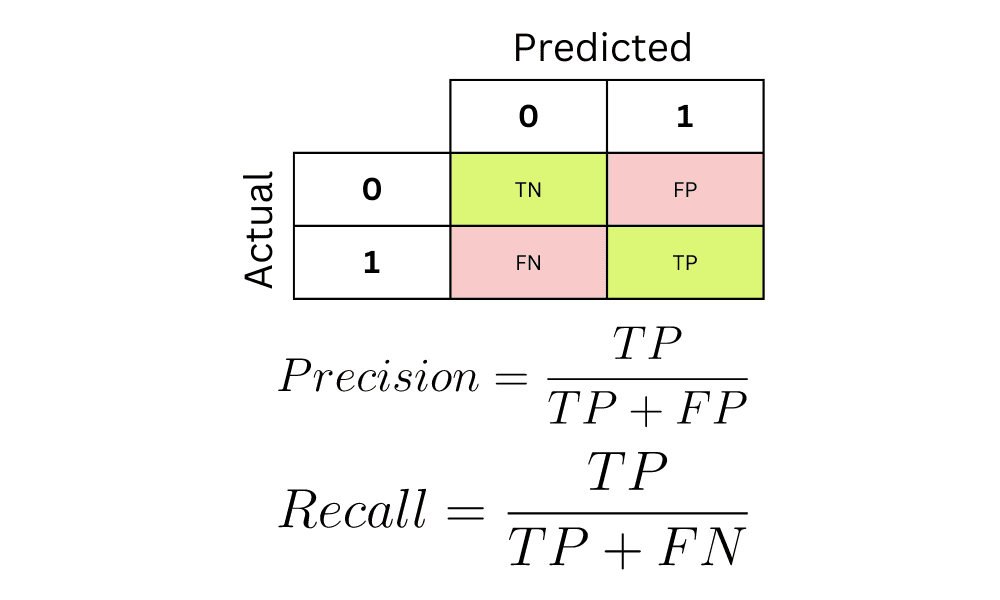

#### Recall scores:

_A recall mérőszám azt mutatja meg, hogy az összes valós pozitív esetből hányat ismert fel a modell. Mindezt százalékos formában._
  
Tehát esetünkben azt mutatja meg, hogy az összes valós Clinton tweet-ből hányat ismert fel a modell Clinton tweet-ként.  
Vagy Trump tweet-jeiből hányat ismert fel Trump tweet-ként.
 $$\text{Recall}=\frac{TP}{TP+FN}$$

In [26]:
print("Naive Bayes".ljust(20), metrics.recall_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC".ljust(20), metrics.recall_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression".ljust(20), metrics.recall_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree".ljust(20), metrics.recall_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest".ljust(20), metrics.recall_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))

Naive Bayes          0.8326996197718631
SVC                  0.8212927756653993
Logistic Regression  0.8479087452471483
Decision Tree        0.7946768060836502
Random Forest        0.8783269961977186


#### Precision scores:

_A precision mérőszám azt mutatja meg, hogy az összes pozitív előrejelzésből hány volt valóban pozitív. Mindezt százalékos formában._  

Tehát esetünkben azt mutatja meg, hogy az összes előrejelzett Clinton tweet-ből hány volt valóban Clinton tweet.  
Vagy Trumpnak jelzett tweetekből hány volt valóban Trump tweet.

In [27]:
print("Naive Bayes".ljust(20), metrics.precision_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC".ljust(20), metrics.precision_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression".ljust(20), metrics.precision_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree".ljust(20), metrics.precision_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest".ljust(20), metrics.precision_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))

Naive Bayes          0.8326996197718631
SVC                  0.8709677419354839
Logistic Regression  0.8643410852713178
Decision Tree        0.8260869565217391
Random Forest        0.8619402985074627


#### f1-scores of the models

Azokban az esetekben, amikor a recall-t vagy precision-t szeretnénk maximalizálni, vagy esetleg mindkét mutató egyformán fontos, ezt aggregáltan megtehetjük egy új mérőszám, az $\text{F}_1$ segítségével. Ez a mutató a recall és precision harmonikus átlagaként számítható ki.  

Ennek egyébként létezik egy súlyozott változata is ($\text{F}_\beta$), amiben megadhatjuk a preferált mutatót, de mi most nem ezt használjuk. Ez olyan esetben jöhet jól, amikor az egyik mutató sokkal fontosabb a másiknál, például egy betegség diagnosztizálásánál a recall sokkal fontosabb, mint a precision, mert ha valaki beteg, akkor azt mindenképpen diagnosztizálni kell, de ha valaki egészséges, akkor nem baj, ha tévesen betegnek diagnosztizálják, majd a kontroll vizsgálatok során kiderül, hogy egészséges.

In [28]:
print("Naive Bayes".ljust(20), metrics.f1_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC".ljust(20), metrics.f1_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression".ljust(20), metrics.f1_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree".ljust(20), metrics.f1_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest".ljust(20), metrics.f1_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))

Naive Bayes          0.832699619771863
SVC                  0.8454011741682974
Logistic Regression  0.8560460652591172
Decision Tree        0.8100775193798451
Random Forest        0.8700564971751411


### Classification reports

A fenti mutatók csak Hillary Clintonra vannak megadva, itt láthatók összesítve a modellek eredményei.

In [29]:
# classification report
report_nb = metrics.classification_report(y_test, tf_idf_nb_pred, labels=target_values, output_dict=True)
report_svm = metrics.classification_report(y_test, tf_idf_svc_pred, labels=target_values, output_dict=True)
report_lr = metrics.classification_report(y_test, tf_idf_lr_pred, labels=target_values, output_dict=True)
report_dt = metrics.classification_report(y_test, tf_idf_dt_pred, labels=target_values, output_dict=True)
report_rf = metrics.classification_report(y_test, tf_idf_rf_pred, labels=target_values, output_dict=True)


df_nb = pd.DataFrame.from_dict(report_nb).transpose()
df_svm = pd.DataFrame.from_dict(report_svm).transpose()
df_lr = pd.DataFrame.from_dict(report_lr).transpose()
df_dt = pd.DataFrame.from_dict(report_dt).transpose()
df_rf = pd.DataFrame.from_dict(report_rf).transpose()

report_dict = {
    "Naive Bayes": df_nb,
    "SVM": df_svm,
    "Logistic Regression": df_lr,
    "Decision Tree": df_dt,
    "Random Forest": df_rf
}

for model, report in report_dict.items():
    print(model)
    print(report)
    print("\n")

Naive Bayes
                 precision    recall  f1-score     support
HillaryClinton    0.832700  0.832700  0.832700  263.000000
realDonaldTrump   0.858065  0.858065  0.858065  310.000000
accuracy          0.846422  0.846422  0.846422    0.846422
macro avg         0.845382  0.845382  0.845382  573.000000
weighted avg      0.846422  0.846422  0.846422  573.000000


SVM
                 precision    recall  f1-score     support
HillaryClinton    0.870968  0.821293  0.845401  263.000000
realDonaldTrump   0.855385  0.896774  0.875591  310.000000
accuracy          0.862129  0.862129  0.862129    0.862129
macro avg         0.863176  0.859033  0.860496  573.000000
weighted avg      0.862537  0.862129  0.861734  573.000000


Logistic Regression
                 precision    recall  f1-score    support
HillaryClinton    0.864341  0.847909  0.856046  263.00000
realDonaldTrump   0.873016  0.887097  0.880000  310.00000
accuracy          0.869110  0.869110  0.869110    0.86911
macro avg         0.

Észrevehető, hogy a legtöbb modell közül a random forest az, ahol a legnagyobb valószínűséggel becsüli a True Positive értékeket. 

Fontos megjegyezni, hogy mindkét vizsgált modell esetében Donald Trump tweetjei azok, amik jobban előrejelezhetők voltak Hillary Clintonnal szemben. Clinton esetében több pozitív esetet is hamisan becsült a modell a döntési fa esetében, viszont a random forestnél közel 0.08-dal magasabb értéket ért el. A döntési fa közel minden mutató esetében (precision, recall és F1) gyengébb eredményt produkált a többi modellhez mérve. 


### Roc-auc scores of the models

A ROC-AUC az egyik legfontosabb mérőszám, hiszen megmutatja, hogy maga a modell mennyire hatékony. 

Ezt onnan láthatjuk, hogy minél magasabb az AUC, annál jobb a modell teljesítménye a pozitív és negatív osztályok megkülönböztetésében. Az 1-es AUC érték azt jelenti, hogy tökéletesen meg tudja különböztetni az összes pozitív és negatív osztálypontot. 

A 0 AUC-érték azt mutatja, hogy minden negatívot pozitívnak jósol, és fordítva is. A 0.5-es érték esetében azt jelenti a modellre nézve, hogy az osztályozó nem működik. 

A 0.5 feletti AUC-érték alapján az osztályozó több True Positive és True Negative eredményt tud felismerni, mint False Negative és False Positive eredményt. 

Magyarán minél szélsőségesebb (helyes) valószínűségeket dob ki a modell, annál magasabb az AUC érték.

Esetünkben az 1-es értéket igen megközelítette a random forest modellből származó 0.95-ös érték.  

In [30]:
print("Naive Bayes".ljust(20), metrics.roc_auc_score(y_test, tf_idf_nb.predict_proba(tfidf_test)[:,1]))
print("SVC does not support predict_proba")
print("Logistic Regression".ljust(20), metrics.roc_auc_score(y_test, tf_idf_lr.predict_proba(tfidf_test)[:,1]))
print("Decision Tree".ljust(20), metrics.roc_auc_score(y_test, tf_idf_dt.predict_proba(tfidf_test)[:,1]))
print("Random Forest".ljust(20), metrics.roc_auc_score(y_test, tf_idf_rf.predict_proba(tfidf_test)[:,1]))

Naive Bayes          0.922758493805961
SVC does not support predict_proba
Logistic Regression  0.9346436894394701
Decision Tree        0.8494296577946767
Random Forest        0.9503618300012265


## Extra: Bootstrapping

In [31]:
accuracies=[]
print("Eredeti adatbázisban a sorok száma", tweet_df.shape[0])
print("Egyedi megfigyelések száma:\n", tweet_df.nunique(), sep="")

for _ in range(1000):  # 1000-szer futtatjuk le a bootstrapet
    """
    200 elemű bootstrap minta, ha szeretnéd módisítani a méretét, akkor itt tedd, az n=200 részt, 
    ha frac=0.9-et írsz be akkor 90%-os lesz a bootstrap minta, de egyszerre csak az egyik paramétert használd
    """
    bs_df = tweet_df.sample(n=200, replace=True, axis=0)  
    X_train, X_test, y_train, y_test = train_test_split(bs_df["status"], bs_df["author"], test_size=0.8, stratify=bs_df["author"], random_state=42)
    
    tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=0.01, max_df=0.9)
    tfidf_train = tfidf_vectorizer.fit_transform(X_train)
    tfidf_test = tfidf_vectorizer.transform(X_test)
    
    bs_svm = LinearSVC(C=0.1, dual="auto")
    bs_svm.fit(tfidf_train, y_train)
    accuracies.append(bs_svm.score(tfidf_test, y_test))    

Eredeti adatbázisban a sorok száma 5722
Egyedi megfigyelések száma:
author       2
status    5714
dtype: int64


95% confidence interval: 0.594 - 0.800
Median: 0.700


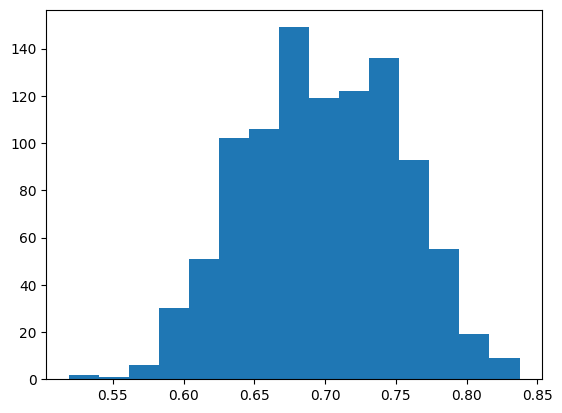

In [32]:
# Create a histogram of the accuracies
accuracies = np.array(accuracies)
plt.hist(accuracies, bins=15)

percentiles = np.percentile(accuracies, [2.5, 97.5])
print(f"95% confidence interval: {percentiles[0]:.3f} - {percentiles[1]:.3f}")
print(f"Median: {np.median(accuracies):.3f}")